In [1]:
import pandas as pd
from datetime import datetime,timedelta
import requests
import json

In [2]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

In [19]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'Haolin Pan'
    
    # 策略参数
    fastPeriod = 20
    slowPeriod = 40
    BBandPeriod = 20
    rsiPeriod = 11
    stopRatio = 0.04
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    bollStatus = {} # 记录boll状态，多头1，空头-1
    rsiTrend = {} #记录rsi状态，超卖1，超买-1
    turnOver = {} #记录反转状态，空转多1，多转空-1
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'BBandPeriod',
                 'rsiPeriod',
                 'stopRatio'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice',
                'bollStatus',
                'rsiTrend',
                'turnOver'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.rsiTrend = {s:0 for s in self.symbolList}
        self.bollStatus = {s:0 for s in self.symbolList}
        self.turnOver = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop) or (self.turnOver[symbol]==-1):#达到止损价位或反转
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif (bar.close > longProfit) and (self.turnOver[symbol]==-1):#达到止盈价位且反转
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop) or (self.turnOver[symbol]==1):#达到止损价位或反转
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit) and (self.turnOver[symbol]==1):#达到止盈价位且反转
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势        
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        #均线金叉
        if fastMa[-1]>slowMa[-1] and fastMa[-2]<slowMa[-2]:
            self.maTrend[symbol] = 1
        #均线死叉
        elif fastMa[-1]<slowMa[-1] and fastMa[-2]>slowMa[-2]:
            self.maTrend[symbol] = -1
        
        #反转
        if self.maTrend[symbol] == -1 and fastMa[-1]>fastMa[-3]:
            self.turnOver[symbol]=1
        if self.maTrend[symbol] == 1 and fastMa[-1]<fastMa[-3]:
            self.turnOver[symbol]=-1

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        #rsi
        rsi = ta.RSI(am15.close, self.rsiPeriod)
        
        if rsi[-1]<30 and rsi[-2]>30: #进入超卖区间
            self.rsiTrend[symbol]=1
        elif rsi[-1]>70 and rsi[-2]<70: #进入超买区间
            self.rsiTrend[symbol]=-1

        #rsi趋势      
        rsiUp = rsi[-1]>rsi[-3]
        rsiDn = rsi[-1]<rsi[-3]
        
        #布林通道
        up, mid, low = ta.BBANDS(am15.close, self.BBandPeriod) 
        
        if (am15.close[-1] < low[-1]):
            self.bollStatus[symbol]=1
        elif (am15.close[-1] > up[-1]):
            self.bollStatus[symbol]=-1
        else:
            self.bollStatus[symbol]=0
        
        #价格趋势
        priceUp = am15.close[-1]>am15.close[-3]
        priceDn = am15.close[-1]<am15.close[-3]
        
        # 反转，趋势为多头，多头没有持仓
        if (self.turnOver[symbol]==1) and (self.posDict[symbol+'_LONG']==0):
            # rsi超卖且上升
            if (rsiUp and (self.rsiTrend[symbol] == 1)) and not (priceUp and (self.bollStatus[symbol]==1)):
                if (self.posDict[symbol+'_SHORT']==0):
                    self.buy(symbol, bar.close*1.01, self.lot)
                elif (self.posDict[symbol+'_SHORT'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, self.lot)
            # 价格跌破布林low且上升
            elif not (rsiUp and (self.rsiTrend[symbol] == 1)) and (priceUp and (self.bollStatus[symbol]==1)):
                if (self.posDict[symbol+'_SHORT']==0):
                    self.buy(symbol, bar.close*1.01, self.lot)
                elif (self.posDict[symbol+'_SHORT'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, self.lot)
            # 上面两者同时满足
            elif rsiUp and (self.rsiTrend[symbol] == 1) and priceUp and (self.bollStatus[symbol]==1):
                if (self.posDict[symbol+'_SHORT']==0):
                    self.buy(symbol, bar.close*1.01, 3*self.lot)
                elif (self.posDict[symbol+'_SHORT'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, 3*self.lot)
        # 反之                      
        if (self.turnOver[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0):
            if (rsiDn and (self.rsiTrend[symbol] == -1)) and not (priceDn and (self.bollStatus[symbol]==-1)):
                if (self.posDict[symbol+'_LONG']==0):
                    self.short(symbol, bar.close*0.99, self.lot)
                elif (self.posDict[symbol+'_LONG'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*1.01, self.posDict[symbol+'_LONG']) 
                    self.short(symbol, bar.close*0.99, self.lot)
            elif not (rsiDn and (self.rsiTrend[symbol] == -1)) and (priceDn and (self.bollStatus[symbol]==-1)):
                if (self.posDict[symbol+'_LONG']==0):
                    self.short(symbol, bar.close*0.99, self.lot)
                elif (self.posDict[symbol+'_LONG'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*1.01, self.posDict[symbol+'_LONG']) 
                    self.short(symbol, bar.close*0.99, self.lot)
            elif (rsiDn and (self.rsiTrend[symbol] == -1)) and (priceDn and (self.bollStatus[symbol]==-1)):
                if (self.posDict[symbol+'_LONG']==0):
                    self.short(symbol, bar.close*0.99, 3*self.lot)
                elif (self.posDict[symbol+'_LONG'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*1.01, self.posDict[symbol+'_LONG']) 
                    self.short(symbol, bar.close*0.99, 3*self.lot)
            
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000029519B0E048>, <__main__.MultiFrameMaStrategy object at 0x0000029519060048>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x000002951961AA60>, <__main__.MultiFrameMaStrategy object at 0x0000029519060048>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x000002951961A840>, <__main__.MultiFrameMaStrategy object at 0x0000029519060048>)
2018-12-19 09:10:30.757214	开始回测
2018-12-19 09:10:30.757214	策略初始化
2018-12-19 09:10:30.760203	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)


2018-12-19 09:10:31.470405	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 09:10:31.475394	载入完成，数据量：12000
2018-12-19 09:10:31.477416	策略初始化完成
2018-12-19 09:10:31.478387	策略启动完成
2018-12-19 09:10:31.479384	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 09:10:31.517318	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)


2018-12-19 09:10:47.801416	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 09:10:47.905571	载入完成，数据量：261728
2018-12-19 09:10:47.908564	当前回放数据:[20180601 12:00,20181201 12:00)


[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 09:10:47.911523	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)


2018-12-19 09:10:48.199753	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 09:10:48.202781	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 09:10:48.237687	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)


2018-12-19 09:10:50.998309	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-12-19 09:10:51.019258	载入完成，数据量：44450
2018-12-19 09:10:51.029222	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 09:10:51.068085	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 09:10:51.070084	！！ 数据量为 0 ！！


Traceback (most recent call last):
  File "C:\Users\49978\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev1811225-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\49978\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000


[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000


[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531111500 , 20180601120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180601120000


[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7491.22, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.8287040000002, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000


2018-06-03 12:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-06-07 05:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-06-09 17:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-06-12 02:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-06-14 11:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-06-14 22:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-06-17 01:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}
SHORT stopLoss


2018-06-17 21:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-06-18 04:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-06-20 03:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-06-21 19:15:00

 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-06-24 02:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-06-24 13:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-06-25 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-06-28 06:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-06-28 21:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-06-30 05:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-07-01 08:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-07-02 13:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-07-04 21:45:00

 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}
SHORT stopLoss


2018-07-05 07:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-07-06 20:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-07-07 21:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-07-08 08:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}


SHORT stopLoss
2018-07-10 08:00:00

 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-07-10 20:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-07-14 04:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-07-15 00:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-07-19 18:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss
2018-07-20 15:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-07-21 01:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-07-23 11:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-07-24 14:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-07-24 20:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-07-28 00:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}
SHORT stopLoss


2018-07-28 22:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss
2018-07-29 16:45:00

 {'BTCUSDT:binance_LONG': 3, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-07-30 08:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-08-02 08:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss

2018-08-03 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-08-04 06:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-08-05 18:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}
SHORT stopLoss


2018-08-05 23:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-08-07 15:45:00

 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}
SHORT stopLoss
2018-08-08 04:45:00 {'BTCUSDT:binance_LONG': 3, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-08-10 11:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-08-12 08:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-08-12 23:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-08-16 08:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-08-16 15:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-08-17 05:30:00 {'BTCUSDT:binance_LONG': 3, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss

2018-08-19 19:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-08-21 15:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-08-23 00:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-08-23 22:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-08-26 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-08-27 18:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-08-28 20:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-08-31 21:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-09-03 00:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss
2018-09-04 13:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-09-06 22:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-09-07 18:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-09-08 15:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-09-09 02:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-09-11 04:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-09-12 19:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-09-15 13:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-09-16 07:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-09-17 08:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-09-19 17:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-09-19 19:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-09-21 16:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-09-26 13:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-09-28 04:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss

2018-09-30 06:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss
2018-09-30 17:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-10-02 15:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-10-06 06:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 3}
SHORT stopLoss
2018-10-06 20:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-10-08 08:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss
2018-10-08 14:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-10-09 18:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-10-12 12:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-10-14 03:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-10-15 15:15:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-10-17 02:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-10-23 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-10-25 00:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-10-26 07:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-10-27 18:00:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-10-29 20:00:00 {'BTCUSDT:binance_LONG': 3, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-11-01 21:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-11-05 17:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-11-05 22:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-11-06 14:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-11-08 06:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-11-11 08:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-11-12 08:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-11-13 06:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-11-14 18:00:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-11-16 09:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-11-18 01:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}
SHORT stopLoss


2018-11-18 19:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-11-19 07:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-11-21 14:30:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-11-22 16:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss
2018-11-24 06:15:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss
2018-11-24 20:30:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


SHORT stopLoss


2018-11-26 22:45:00 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}
LONG stopLoss


2018-11-28 02:15:00

 {'BTCUSDT:binance_LONG': 1, 'BTCUSDT:binance_SHORT': 0}


LONG stopLoss


2018-11-30 01:45:00 {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 1}


2018-12-19 09:11:19.149215	数据回放结束
2018-12-19 09:11:19.150137	计算按日统计结果
2018-12-19 09:11:19.186042	------------------------------
2018-12-19 09:11:19.186042	首个交易日：	2018-06-01 00:00:00
2018-12-19 09:11:19.187038	最后交易日：	2018-12-01 00:00:00
2018-12-19 09:11:19.187038	总交易日：	184
2018-12-19 09:11:19.187038	盈利交易日	88
2018-12-19 09:11:19.187038	亏损交易日：	79
2018-12-19 09:11:19.187038	起始资金：	100000
2018-12-19 09:11:19.187038	结束资金：	105,562.46
2018-12-19 09:11:19.187038	总收益率：	5.56%
2018-12-19 09:11:19.187038	年化收益：	7.26%
2018-12-19 09:11:19.187038	总盈亏：	5,562.46
2018-12-19 09:11:19.187038	最大回撤: 	-855.91
2018-12-19 09:11:19.187038	百分比最大回撤: -0.84%
2018-12-19 09:11:19.187038	总手续费：	880.89
2018-12-19 09:11:19.187038	总滑点：	0.53
2018-12-19 09:11:19.187038	总成交金额：	1,761,776.58
2018-12-19 09:11:19.187038	总成交笔数：	223
2018-12-19 09:11:19.187038	日均盈亏：	30.23
2018-12-19 09:11:19.187038	日均手续费：	4.79
2018-12-19 09:11:19.187038	日均滑点：	0.0
2018-12-19 09:11:19.187038	日均成交金额：	9,574.87
2018-12-19 09:11:19.187038	日均成交笔数：	1.21
2018-

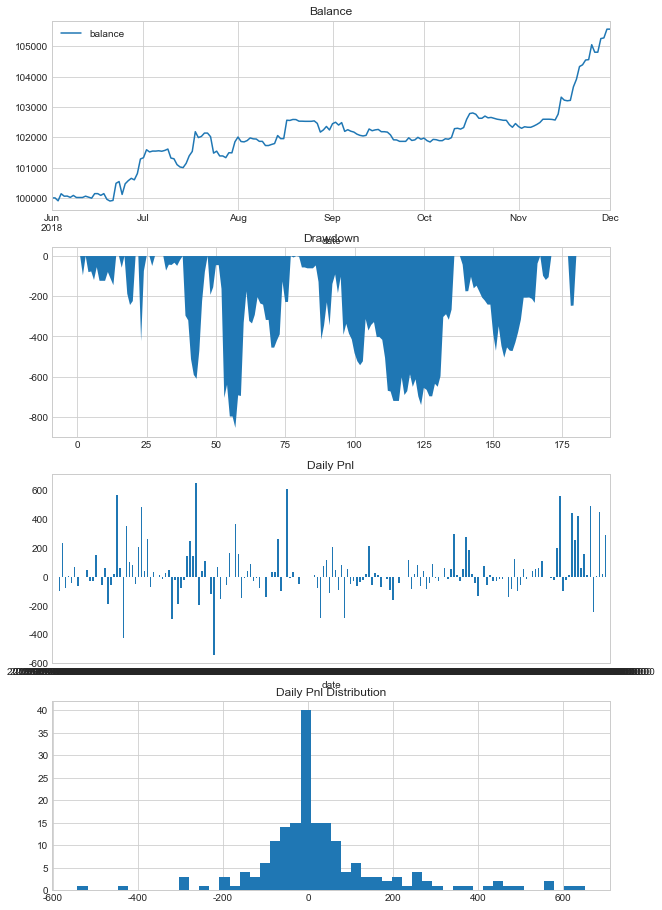

2018-12-19 09:11:22.830343	计算回测结果
2018-12-19 09:11:22.852440	------------------------------
2018-12-19 09:11:22.852440	第一笔交易：	2018-06-06 01:00:00
2018-12-19 09:11:22.852440	最后一笔交易：	2018-12-01 11:58:00
2018-12-19 09:11:22.852440	总交易次数：	112
2018-12-19 09:11:22.852440	总盈亏：	5,560.44
2018-12-19 09:11:22.852440	最大回撤: 	-898.73
2018-12-19 09:11:22.852440	平均每笔盈利：	49.65
2018-12-19 09:11:22.852440	平均每笔滑点：	0.0
2018-12-19 09:11:22.852440	平均每笔佣金：	7.88
2018-12-19 09:11:22.852440	胜率		50.0%
2018-12-19 09:11:22.852440	盈利交易平均值	183.04
2018-12-19 09:11:22.852440	亏损交易平均值	-83.74
2018-12-19 09:11:22.852440	盈亏比：	2.19


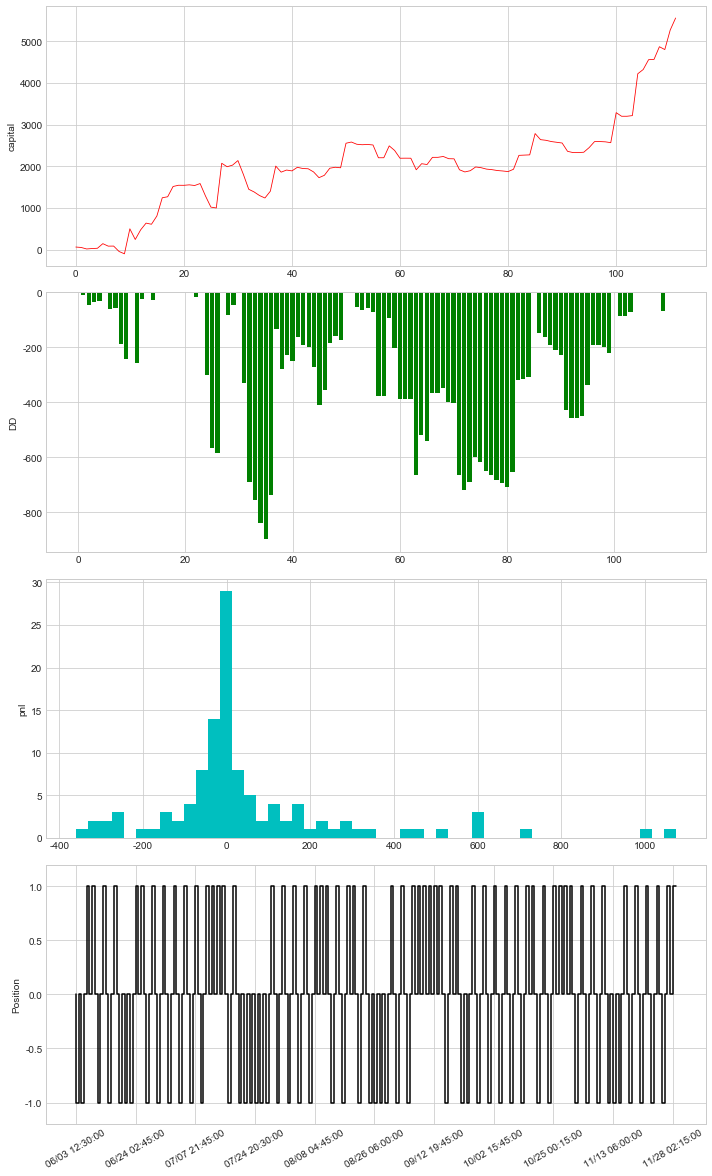

2018-12-19 09:11:24.145860	计算按日统计结果


In [20]:
MultiFrameMaDf = runBacktesting(MultiFrameMaStrategy, {'symbolList':['BTCUSDT:binance']} , '20180601 12:00', \
                            '20181201 12:00', 0.002, 5/10000)